# Проектная работа. Анализ бизнес-показателей. <a class="tocSkip">

Нашей задачей является снижение расходов — отказаться от невыгодных источников трафика и перераспределить бюджет.
У нас имеются данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Необходимо изучить:

* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Шаг 1. Загрузите данные и подготовьте их к анализу

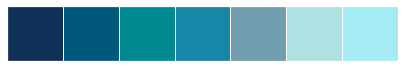

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
colors = ['#0f3057','#00587a','#008891','#1687a7', '#719fb0', '#aee1e1', '#a4ebf3']
sns.palplot(sns.color_palette(colors))
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import datetime as dt

In [2]:
visits = pd.read_csv('../datasets/business_metrics_analysis_visits_log.csv')
orders = pd.read_csv('../datasets/business_metrics_analysis_orders_log.csv')
costs = pd.read_csv('../datasets/business_metrics_analysis_costs.csv')

Посмотрим данные из таблицы Visits. 

In [3]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
61683,desktop,2018-02-21 15:28:00,4,2018-02-21 15:24:00,11567833330448998350
23435,touch,2017-12-01 18:24:00,3,2017-12-01 18:12:00,18414897972804866901
232633,desktop,2018-03-18 17:00:00,4,2018-03-18 16:59:00,15527029198542038804
299833,desktop,2017-09-04 01:53:00,5,2017-09-04 01:42:00,3394392439183433884
213400,desktop,2017-07-11 17:43:00,2,2017-07-11 17:12:00,12265260457948446682


Переведем названия столбцов к нижнему регистру и переименуем столбцы.

In [4]:
visits.columns = visits.columns.str.lower()
visits = visits.rename({'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts' }, axis=1)

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


После выгрузки информации видим. что у нас полные данные без пропущенных значений, всего по 359 400 значений в каждом столбце. Имеются 3 переменные типа object и 3 переменные типа int.


In [6]:
display(visits.describe().T)
display(visits.describe(include = ['object']))

,count,mean,std,min,25%,50%,75%,max
source_id,359400.0,3.750515e+00,1.917116e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
uid,359400.0,9.202557e+18,5.298433e+18,1.186350e+13,4.613407e+18,9.227413e+18,1.372824e+19,1.844668e+19


,device,end_ts,start_ts
count,359400,359400,359400
unique,2,224760,224303
top,desktop,2017-11-24 16:51:00,2017-11-24 16:06:00
freq,262567,23,19


Чтобы оптимизировать время работы кода понизим разрядность столбца source_id. И переведем столбцы с датой из объектных данных в формат даты для дальнейшей работы.

Напишем 2 функции - для понижения разрядности и перевода даты из формата object в формат даты.

In [7]:
def downcast(data, column, type_data):
    '''
    input:
    downcast - функция понижения разрядности
    data - данные
    column - cтолбец, который переводим в другой формат
    type_data - в какой формат переводим
    '''
    data[column] = pd.to_numeric(data[column], downcast=type_data)

In [8]:
downcast(visits, 'source_id', 'signed')

In [9]:
def into_datetime(data, column):
    '''
    Функция перевода в формат даты
    input:
        data - данные
        column - cтолбец, который переводим в другой формат
    '''
    data[column] = pd.to_datetime(data[column])

In [10]:
into_datetime(visits, 'start_ts')
into_datetime(visits, 'end_ts')

Рассмотрим таблицу с заказами.

In [11]:
orders.sample(5)

,Buy Ts,Revenue,Uid
49771,2018-05-30 21:33:00,5.50,1356909309642899762
2154,2017-06-28 14:01:00,3.67,2324659397610343872
37383,2018-02-28 15:18:00,3.67,5631771076810950705
42124,2018-03-26 19:13:00,4.44,4099361297077842146
11575,2017-10-08 04:26:00,0.61,4435869172654557190


Переведем названия столбцов к нижнему регистру и переименуем столбцы.

In [12]:
orders.columns = orders.columns.str.lower()
orders = orders.rename({'buy ts':'buy_ts'}, axis=1)

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


После выгрузки информации видим, что у нас полные данные без пропущенных значений, всего по 50 415 значений в каждом столбце. Имеются 1 переменная типа object и 1 переменная типа uint и переменная с плавающей точкой.

In [14]:
display(orders.describe().T)
display(orders.describe(include = ['object']))

,count,mean,std,min,25%,50%,75%,max
revenue,50415.0,4.999647e+00,2.181836e+01,0.000000e+00,1.220000e+00,2.500000e+00,4.890000e+00,2.633280e+03
uid,50415.0,9.098161e+18,5.285742e+18,3.135781e+14,4.533567e+18,9.102274e+18,1.368290e+19,1.844617e+19


,buy_ts
count,50415
unique,45991
top,2018-05-31 10:13:00
freq,9


Чтобы оптимизировать время работы кода понизим разрядность столбца revenue. И переведем столбец с датой из объектных данных в формат даты для дальнейшей работы.

In [15]:
downcast(orders, 'revenue', 'float')
into_datetime(orders, 'buy_ts')

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float32       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.8 KB


Рассмотрим таблицу с расходами.

In [17]:
costs.sample(5)

,source_id,dt,costs
555,2,2017-12-10,164.37
864,3,2017-10-17,515.74
995,3,2018-02-25,455.87
411,2,2017-07-19,73.14
2086,9,2018-02-26,28.02


In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [19]:
display(costs.describe().T)
display(costs.describe(include = ['object']).T)

,count,mean,std,min,25%,50%,75%,max
source_id,2542.0,4.857199,3.181581,1.00,2.000,4.000,9.000,10.00
costs,2542.0,129.477427,156.296628,0.54,21.945,77.295,170.065,1788.28


,count,unique,top,freq
dt,2542,364,2017-10-17,7


Видим, что пропущенных значений нет, каждый столбец включает в себя по 2541 значений. Видим, что можем понизить разрядность столбцов source_id и costs для оптимизации работы кода, а также перевести столбец dt в формат даты.

In [20]:
downcast(costs, 'source_id', 'signed')
downcast(costs, 'costs', 'float')
into_datetime(costs, 'dt')

### Вывод

В данном блоке мы выгрузили проанализировали 3 таблицы:
* visits (визиты)
* orders (заказы)
* costs(расходы)

Данные в таблицах без пропусков. Мы оптимизировали время отработки кода понизив разрядность столбцов и перевели некоторые данные типа "object" в формат даты.

## Шаг 2. Рассчитайте метрики и постройте графики

### Продуктовые метрики

####  DAU, WAU и MAU. Вычисление средних значений этих метрик за весь период

Для того чтобы в дальнейшем посчитать DAU, WAU и MAU выделим в отдельные столбцы год, месяц, неделю и полную дату.

In [21]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid
141895,desktop,2018-01-29 18:47:00,5,2018-01-29 18:34:00,8211180112370244213
11530,desktop,2017-07-11 12:57:00,1,2017-07-11 12:50:00,1186757012633220834
225878,desktop,2017-11-16 12:38:00,3,2017-11-16 12:36:00,4636442759290118482
11865,touch,2017-12-13 08:18:00,1,2017-12-13 08:17:00,12247838128872775087
195699,desktop,2017-12-22 14:48:00,4,2017-12-22 14:47:00,8968752255074728429


In [22]:
visits['session_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

In [23]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27


Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдем среднее.

In [24]:
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
dau_table = visits.groupby('session_date').agg({'uid':'nunique'}).reset_index()
mau_total = visits.groupby('session_month').agg({'uid':'nunique'}).mean()
mau_table = visits.groupby('session_month').agg({'uid':'nunique'}).reset_index()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
wau_table = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).sort_values(by=['session_year', 'session_week']).reset_index()


In [25]:
print('DAU (количество уникальных пользователей в день)', int(dau_total))
print('MAU (количество уникальных пользователей в месяц)', int(mau_total))
print('WAU (количество уникальных пользователей в неделю)', int(wau_total))

DAU (количество уникальных пользователей в день) 907
MAU (количество уникальных пользователей в месяц) 23228
WAU (количество уникальных пользователей в неделю) 5621


Итак, мы получили, что количество уникальных пользователей в день (DAU) составляет 907, количество уникальных пользователей в неделю (WAU) - 5825, количество уникальных пользователей в месяц - 23 228. 

Построим графики DAU, MAU и WAU для визуального анализа данных показателей в динамике.

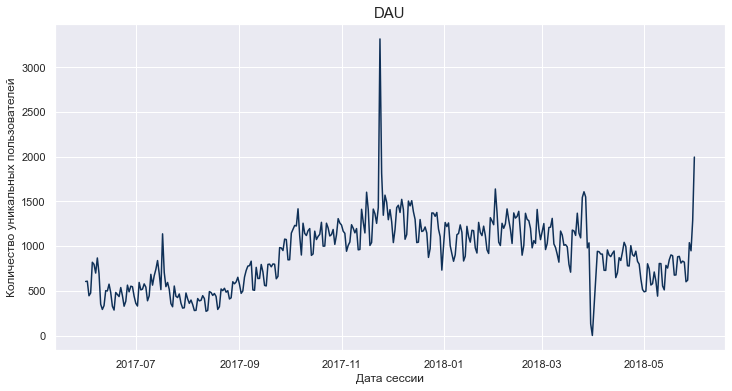

In [26]:
plt.figure(figsize = (12,6))
plt.title('DAU', size = 15)
sns.lineplot(data=dau_table, x="session_date", y="uid", color='#0f3057')
plt.xlabel('Дата сессии')
plt.ylabel('Количество уникальных пользователей')
plt.show()

По графику видим, что среднее количество уникальных пользователей в конце ноября 2018 года резко возросло почти до 3500 пользователей, в то время как в апреле резко снизилось почти что до 0.

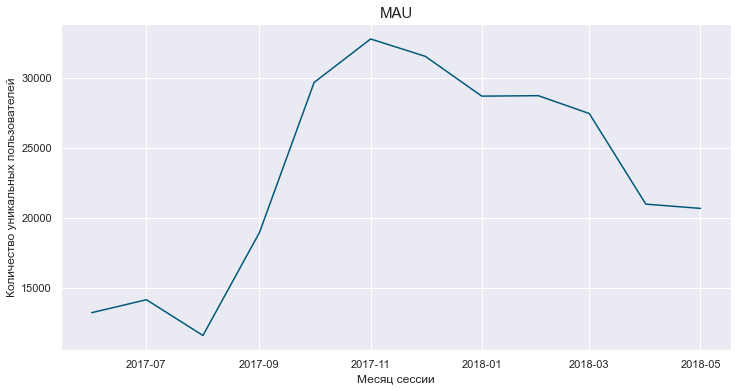

In [27]:
plt.figure(figsize = (12,6))
plt.title('MAU', size = 15)
sns.lineplot(data=mau_table, x="session_month", y="uid", color='#00587a')
plt.xlabel('Месяц сессии')
plt.ylabel('Количество уникальных пользователей')
plt.show()

Видим самое высокое количество уникальных посетителей в ноябре 2017 года - 3500, а самое низкое - в августе 2017 года.

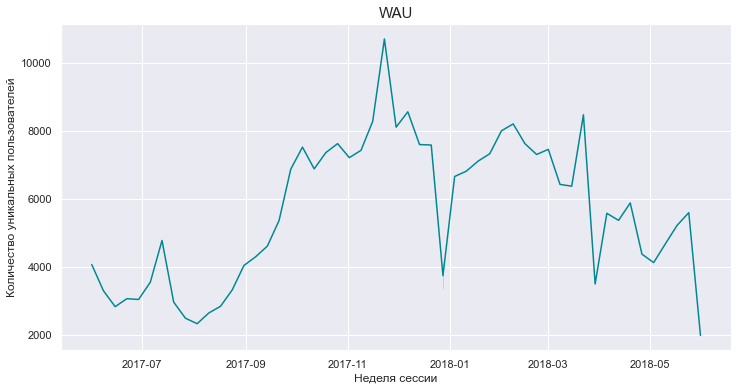

In [28]:
plt.figure(figsize = (12,6))
plt.title('WAU', size = 15)
sns.lineplot(data=wau_table, x="session_week", y="uid", color='#008891')
plt.xlabel('Неделя сессии')
plt.ylabel('Количество уникальных пользователей')
plt.show()

С ноября 2017 года по январь 2018 года видим резкое снижение количества уникальных посетителей - с 12000 до 3800. При этом самое низкое значение наблюдается в августе - 2200.

Посчитаем sticky factors для того чтобы оценить регулярность использования Яндекс.Афиши.

In [29]:
sticky_wau = dau_total / wau_total * 100
sticky_mau = dau_total / mau_total * 100

In [30]:
print('sticky wau:', float(sticky_wau))
print('sticky mau:', float(sticky_mau))

sticky wau: 16.151540637823956
sticky mau: 3.908969652437603


Получили, что sticky factors для WAU равен 15,88%, а для MAU равен 3.9%.

#### Cколько раз за день пользователи в среднем заходят на сайт 

In [31]:
visits['session_date'] = visits['start_ts'].dt.date

In [32]:
sessions_per_user = visits.groupby('session_date').agg({'uid':['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user_sess = sessions_per_user['n_sessions'].sum() / sessions_per_user['n_users'].sum()

In [33]:
sessions_per_user_sess

1.0874136559064957

#### Cколько времени пользователи проводят на сайте. Продолжительность типичной пользовательской сессии за весь период. График распределения. 

In [34]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
17697,touch,2017-12-15 01:03:00,3,2017-12-15 01:02:00,8655181169656678790,2017-01-01,2017-12-01,2017-12-14,2017-12-15
20874,touch,2017-11-15 23:34:00,2,2017-11-15 23:31:00,5534057469442788862,2017-01-01,2017-11-01,2017-11-09,2017-11-15
150115,desktop,2017-12-01 00:31:00,4,2017-12-01 00:30:00,11328346201773848546,2017-01-01,2017-12-01,2017-11-30,2017-12-01
350542,desktop,2017-07-24 18:20:00,2,2017-07-24 18:08:00,17030528792926543083,2017-01-01,2017-07-01,2017-07-20,2017-07-24
132727,desktop,2017-11-13 16:14:00,3,2017-11-13 15:52:00,4037155213585663176,2017-01-01,2017-11-01,2017-11-09,2017-11-13


In [35]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()

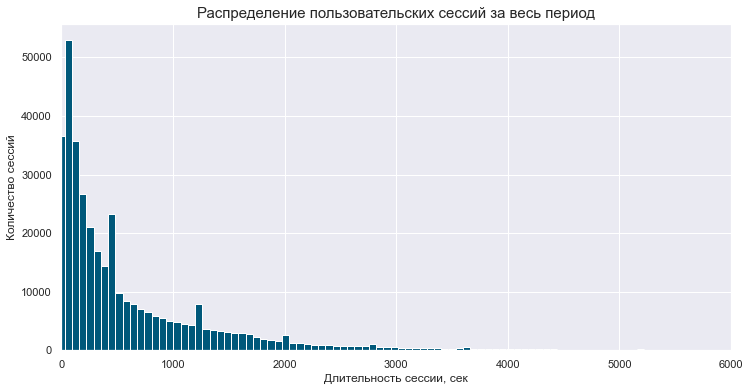

In [36]:
plt.figure(figsize = (12,6))
plt.title('Распределение пользовательских сессий за весь период', size = 15)
plt.hist(visits['session_duration_sec'], bins = 700, color='#00587a')
plt.xlabel('Длительность сессии, сек')
plt.ylabel('Количество сессий')
plt.xlim(0, 6000)
plt.show()

По графику видим, что наибольшее количество сессий продолжалось порядка 100 - 150 сек.(около 55 000 сессий). Распределение наше далеко от нормального, поэтому логичнее будет использовать моду для определения типичной продолжительности сессии зпа весь период вместо медианы или среднего.

In [37]:
asl = visits['session_duration_sec'].mode()
print('Средняя продолжительность сессии составляет: {:.0f} сек.'.format(int(asl)))

Средняя продолжительность сессии составляет: 60 сек.


Получили, что продолжительность типичной пользовательской сессии за весь период составляет 60 секунд.

In [38]:
pd.concat([(visits['end_ts'] - visits['start_ts']).dt.total_seconds().describe().to_frame(name='total_sec'),
(visits['end_ts'] - visits['start_ts']).dt.seconds.describe().to_frame(name='seconds')], axis=1)

,total_sec,seconds
count,359400.000000,359400.000000
mean,643.025687,643.506489
std,997.127761,1016.334786
min,-2760.000000,0.000000
25%,120.000000,120.000000
50%,300.000000,300.000000
75%,840.000000,840.000000
max,42660.000000,84480.000000


####  Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.

In [39]:
into_datetime(visits, 'session_date') #Переводим столбец session date в формат даты

Проведем когортный анализ и посчитаем коэффициент удержания.

In [40]:
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [41]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']


Построим сводную таблицу с полученными результатами.

In [42]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='retention',\
                                      aggfunc='sum')
retention_pivot.index = retention_pivot.index.to_series().dt.strftime('%Y-%m')
retention_pivot.loc['Mean values', :] = retention_pivot.mean()

In [43]:
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,,
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.03586,0.024186,0.022809,,,
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,,,,
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.0218,,,,,
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,,,,,,
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,,,,,,,
2018-02,1.0,0.05708,0.025454,0.020093,,,,,,,,


Построим heatmap для наглядности получившегося результата.

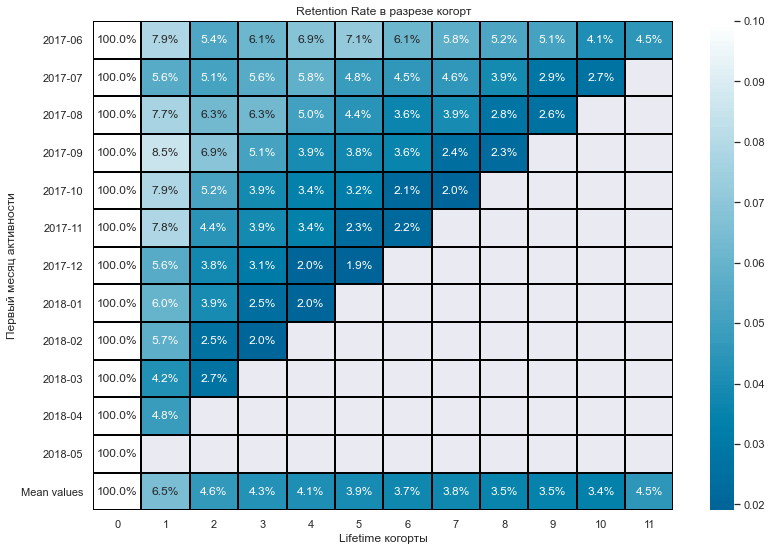

In [44]:
plt.figure(figsize=(13,9))
plt.title('Retention Rate в разрезе когорт')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidth=1, linecolor='black', vmax=0.1, center=0, cmap='ocean')
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц активности')
plt.show()

Видим, что в первый месяц мы теряем больше 90% пользователей. При этом в последующие месяцы пользователи уже не так активно отказываются от услуг сервиса Яндекс.Афиши. Такое ощущение, что Яндекс.Афиша находит свою аудиторию, своих пользователей и удерживает это небольшое количество. Но показатели далеки от идеальных, нужно разбираться почему так много пользователей "отваливается" в течение первого месяца.

Средний Retention Rate на второй месяц «жизни» когорт равен 6,5%. То есть мы теряем почти 93,5% пользователей по сравнению с предыдущим периодом.

#### Вывод

Рассчитав, продуктовые метрики мы получили:

* Количество уникальных пользователей в день (DAU) составляет 907, количество уникальных пользователей в неделю (WAU) - 5825, количество уникальных пользователей в месяц - 23 228.
Данный результат показывает, что мы постоянно привлекаем новых пользователей, они заходят на наш сервис, но пока не понятно насколько нам удается удержать привлеченных пользователей


* Оценили регулярность использования Яндекс.Афиши, рассчитав sticky factors. Получили, что sticky factors для WAU равен 15,88%, а для MAU равен 3.9%. Это не очень высокие показатели, а значит мы еще не сформировали круг лояльных пользователей, которые регулярно пользуются Яндекс.Афишей.


* За день пользователи заходят на сайт Яндекс.Афиши примерно 1,087 раз. Можно сказать, что это вполне объяснимый результат - люди обычно не мониторят по несколько раз на дню дайджест с интересными событиями, потому как правило обновления на таких сайтах не выгружаются каждую минуту. Достаточно 1 раз в день зайти на Яндекс.Афишу чтобы посмотреть куда можно сходить в ближайшее время.


* Наибольшее количество сессий продолжалось порядка 100 - 150 сек.(около 123 000 сессий). При этом получили, что что продолжительность типичной пользовательской сессии за весь период составляет 60 секунд. Возможно такая непродолжительность сессий связана с тем, что сторонние сервисы со сравнением цен от разных источников выкидывают пользователя сразу на страницу с оплатой, из-за чего продолжительность нахождения на сайте Яндекс.Афиши резко сокращается.


* Видим, что в первый месяц мы теряем больше 90% пользователей. При этом в последующие месяцы пользователи уже не так активно отказываются от услуг сервиса Яндекс.Афиши. Такое ощущение, что Яндекс.Афиша находит свою аудиторию, своих пользователей и удерживает это небольшое количество. Но показатели далеки от идеальных, нужно разбираться почему так много пользователей "отваливается" в течение первого месяца.


* Средний Retention Rate на второй месяц «жизни» когорт равен 6,5%. То есть мы теряем почти 94,5% пользователей по сравнению с предыдущим периодом.

### Метрики электронной коммерции

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно

Сгруппируем таблицы 'visits' и 'order' по столбцу 'uid' и найдем дату и время первого посещения сайта и первой покупки.

In [45]:
first_date_visit = visits.groupby(['uid']).agg({'start_ts':'min'}).rename(\
    columns={'min':'first_date_visit'}).reset_index()
first_date_order = orders.groupby(['uid']).agg({'buy_ts':'min'}).rename(\
    columns={'min':'first_date_order'}).reset_index()

Соединим получившиеся таблицы таким образом, чтобы в таблицу попали только те пользователи, которые что-то когда-то купили.

In [46]:
first_date_visit_order = first_date_visit.merge(first_date_order, how='inner', on='uid')

Теперь найдем время, которое прошло с момента первого посещения сайта до первой покупки. В качестве единицы измерения мы выбрали минуты.

In [47]:
first_date_visit_order['difference'] = first_date_visit_order['buy_ts'] - first_date_visit_order['start_ts']
first_date_visit_order['difference_seconds'] = first_date_visit_order['difference'].dt.seconds 
first_date_visit_order['difference_days'] = first_date_visit_order['difference'].dt.days
first_date_visit_order['total_difference_seconds'] = first_date_visit_order['difference_seconds']\
+ first_date_visit_order['difference_days'] * 24 * 60 * 60
first_date_visit_order['total_difference_minutes'] = first_date_visit_order['total_difference_seconds'] / 60

In [48]:
first_date_visit_order_for_hist = first_date_visit_order[['uid', 'total_difference_minutes']] 
#Конечная таблица для построения гистограммы

Построим гистограмму для определения распределения времени с момента первого посещения сайта до совершения покупки.

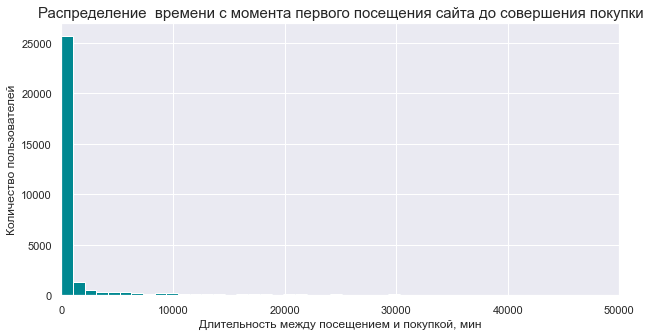

In [49]:
plt.figure(figsize = (10,5))
plt.title('Распределение  времени с момента первого посещения сайта до совершения покупки', size = 15)
plt.hist(first_date_visit_order_for_hist['total_difference_minutes'], bins = 500, color='#008891')
plt.xlabel('Длительность между посещением и покупкой, мин')
plt.ylabel('Количество пользователей')
plt.xlim(0, 50000)
plt.show()

По гистограмме видим, что примерно 255 000 пользователей пердпочитают осуществлять покупки в первый же день, о чем нам говорит сосредоточение пользователей в нулевом значении гистограммы.

В нашем случае для того чтобы корректно определить сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки необходимо использовать моду или медиану вместо среднего. Найдем оба показателя.

In [50]:
print('Мода времени с момента первого посещения сайта до совершения покупки:', 
      int(first_date_visit_order_for_hist['total_difference_minutes'].mode()), 'мин.')
print('Медиана времени с момента первого посещения сайта до совершения покупки:', 
      int(first_date_visit_order_for_hist['total_difference_minutes'].median()), 'мин.')

Мода времени с момента первого посещения сайта до совершения покупки: 1 мин.
Медиана времени с момента первого посещения сайта до совершения покупки: 16 мин.


В результате получили, что с момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут. 

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно

Выгрузим таблицу заказов с рандомными строками, для того чтобы в дальнейшем провести когортный анализ.

In [51]:
orders.sample(5)

,buy_ts,revenue,uid
25633,2017-12-23 20:55:00,11.00,10894749603955764096
1881,2017-06-23 20:22:00,14.67,2096666323031437831
16978,2017-11-10 22:57:00,3.05,17099047222464595435
8525,2017-09-21 15:27:00,173.25,5539673724080479777
21411,2017-12-01 18:15:00,3.91,3943237310022470766


In [52]:
into_datetime(orders, 'buy_ts') #Перевод столбца 'buy_ts' в формат даты

Для того чтобы рассчитать среднее количество покупок на одного покупателя за 6 месяцев, найдем дату первой покупки для каждого пользователя, сгруппируем данные по месяцу первой покупки и месяцу заказа, формируя когорты, найдем количество покупок и уникальных пользователей в каждой когорте, а затем найдем среднее количество покупок на одного покупателя по каждой когорте. Сформируем сводную таблицу, в которой будет отражаться  среднее количество покупок на одного пользователя по месяцам.

In [53]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'

In [54]:
orders = orders.join(first_order_date, on='uid')

In [55]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
cohort_size = orders.groupby('first_order_month').agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
orders_grouped = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'count'}).rename(\
    columns={'revenue':'n_purchase'}).reset_index()
orders_grouped_by_cohorts = pd.merge(cohort_size, orders_grouped, on='first_order_month')
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month']\
                                                - orders_grouped_by_cohorts['first_order_month']) / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')


In [56]:
orders_grouped_by_cohorts['orders_per_person'] = orders_grouped_by_cohorts['n_purchase'] / orders_grouped_by_cohorts['n_buyers']
mean_orders_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                         columns='cohort_lifetime',
                                                         values='orders_per_person', aggfunc='mean')

In [57]:
#Обработка даты для корректного отображения в таблице и на графике heatmap
mean_orders_pivot.index = mean_orders_pivot.index.to_series().dt.strftime('%Y-%m') 

In [58]:
mean_orders_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.163618,0.087494,0.086011,0.111715,0.14434,0.107761,0.136431,0.086011,0.104795,0.07563,0.047454,0.042511
2017-07,1.136765,0.052002,0.062402,0.054082,0.037441,0.042642,0.031721,0.026001,0.030161,0.01248,0.027561,
2017-08,1.118978,0.078832,0.072993,0.059124,0.062044,0.045255,0.035766,0.056934,0.033577,0.033577,,
2017-09,1.136381,0.084851,0.062379,0.063541,0.025959,0.042232,0.041844,0.021697,0.023634,,,
2017-10,1.143779,0.07235,0.037327,0.028111,0.029724,0.023733,0.019816,0.028802,,,,
2017-11,1.179368,0.09728,0.044597,0.051703,0.033325,0.014457,0.024994,,,,,
2017-12,1.152635,0.061602,0.046087,0.04084,0.019621,0.023956,,,,,,
2018-01,1.121554,0.06641,0.047139,0.018974,0.023125,,,,,,,
2018-02,1.121611,0.060805,0.022733,0.019173,,,,,,,,


Данные в таблице не выглядят наглядно, поэтому построим график heatmap для упрощения анализа полученного результата.

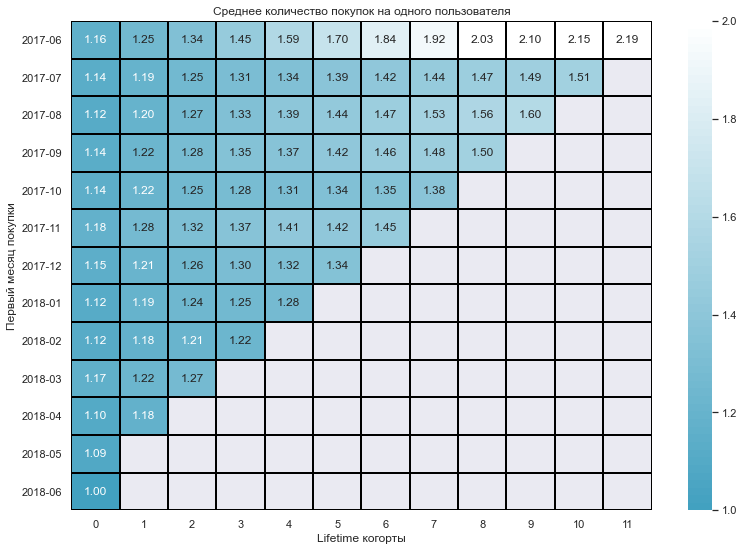

In [59]:
plt.figure(figsize=(13,9))
plt.title('Среднее количество покупок на одного пользователя')
heatmap = sns.heatmap(mean_orders_pivot.cumsum(axis=1), annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=2, center=0, cmap='ocean')
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

По полученному графику видим, что количество заказов на одного человека по каждой когорте составляет меньше 1 покупки в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше. Также видим, что по каждой когорте на первом месяце жизни пользователи делают 1 покупку, а затем данный показатель падает.

Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев в накопительном ключе.

In [60]:
print('Cреднее количество покупок на одного покупателя за 6 месяцев:', 
      round(mean_orders_pivot.cumsum(axis=1).mean(axis=0)[5], 2))

Cреднее количество покупок на одного покупателя за 6 месяцев: 1.43


Получили, что среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43 покупки. Учитывая специфику платформы, можно предположить, что это вполне адекватный результат. Трудоспособная часть населения, у которых есть работа, обычно ходит на выставки, в театр и на другие мероприятия с периодичностью примерно раз в месяц. 

#### Рассчитайте средний чек

Используя когортный анализ посмотрим как изменяется с течением времени средний чек.

In [61]:
average_bill_cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum', 'uid':'nunique'})
average_bill_cohorts['revenue_per_user'] = average_bill_cohorts['revenue'] / average_bill_cohorts['uid']
average_bill_cohorts_pivot = average_bill_cohorts.pivot_table(index='first_order_month', 
                                                              columns='order_month', 
                                                              values='revenue_per_user', 
                                                              aggfunc='mean')

Построим сводную таблицу для отбражения изменений среднего чека с течением времени в разрезе когорт.

In [62]:
average_bill_cohorts_pivot.fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.09541,17.706801,35.764816,23.506592,22.207762,31.011935,25.033193,19.29569,27.233556,25.681334,9.804151,
2017-07-01,,6.010219,12.396346,21.035966,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513847,
2017-08-01,,,5.276518,11.148793,11.851321,12.182954,16.921249,12.139063,9.620334,12.610454,21.069999,8.307419,
2017-09-01,,,,5.644529,22.188385,13.4452,138.669196,19.881538,26.095001,27.437121,16.961352,11.044651,
2017-10-01,,,,,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479702,
2017-11-01,,,,,,5.154683,7.339054,6.786583,12.51066,7.457284,4.580833,7.564839,
2017-12-01,,,,,,,4.738191,7.816575,39.366019,48.135053,27.431399,23.518411,
2018-01-01,,,,,,,,4.135636,8.721228,12.365542,11.199767,4.699555,
2018-02-01,,,,,,,,,4.156987,8.61,4.942414,6.941026,


In [63]:
#Обработка даты для корректного отображения в таблице и на графике heatmap
average_bill_cohorts_pivot.index = average_bill_cohorts_pivot.index.to_series().dt.strftime('%Y-%m') 

Построим heatmap график для наглядности и упрощения анализа получившейся сводной таблицы.

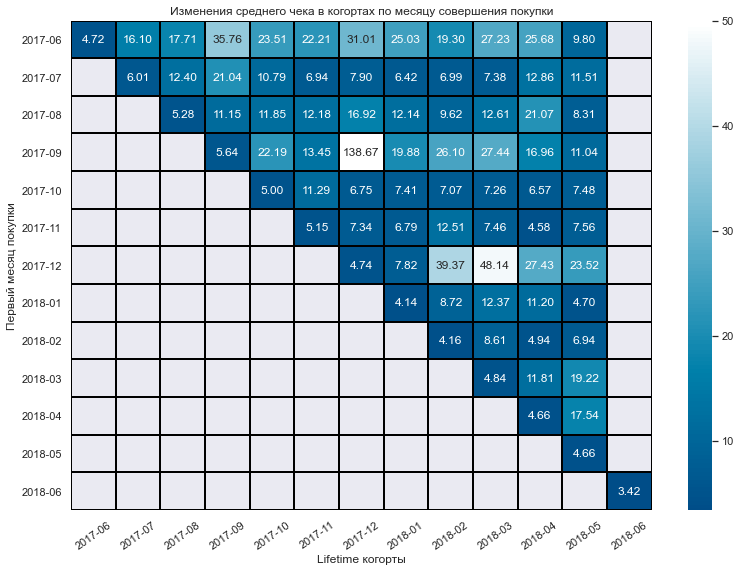

In [64]:
plt.figure(figsize=(13,9))
plt.title('Изменения среднего чека в когортах по месяцу совершения покупки')
heatmap = sns.heatmap(average_bill_cohorts_pivot, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=50, center=0, cmap='ocean')
heatmap.set_xticklabels(average_bill_cohorts_pivot.columns.to_series().dt.strftime('%Y-%m'), rotation=35)
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

По получившемуся графику можно сказать, что какой-либо четкой тенденции повышения/понижения среднего чека по когортам не наблюдается. Видим, что у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67, а также одно из самых высоких значений среднего чека наблюдается у декабрьской когорты в марте - 48.14.

In [65]:
print('Средний чек:', round(orders['revenue'].mean(), 2))

Средний чек: 5.0


Общий средний чек по всем покупателям Яндекс.Афиши равен 5.

#### Выясните, как меняется во времени LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

Сгруппировав таблицу orders по uid пользователя, найдем первый месяц покупки.

In [66]:
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'}).\
               rename(columns={'buy_ts':'first_order_month'}).reset_index()
first_orders['first_order_month'] = first_orders['first_order_month'].astype('datetime64[M]')

Посчитаем количество новых покупателей каждый месяц. Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами. Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [67]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
margin_rate = 1
cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

Найдем валовую прибыль, умножив выручку на маржинальность. И найдем возраст (age) когорты. Посчитаем LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [68]:
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

Построим сводную таблицу с подсчитанным LTV по когортам.

In [69]:
ltv_pivot = report.pivot_table(index='first_order_month', 
                               columns='age', 
                               values='ltv', 
                               aggfunc='mean').cumsum(axis=1).round(2)
ltv_pivot.index = ltv_pivot.index.to_series().dt.strftime('%Y-%m')
ltv_pivot.loc['Mean_values', :] = ltv_pivot.mean().round(2)

In [70]:
ltv_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02,4.16,4.44,4.51,4.59,,,,,,,,


Для большей наглядности, создадим heatmap график по когортам.

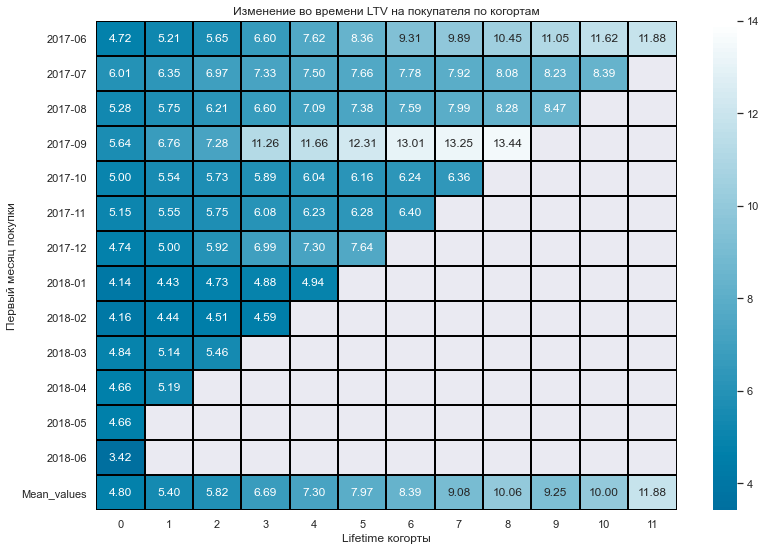

In [71]:
plt.figure(figsize=(13,9))
plt.title('Изменение во времени LTV на покупателя по когортам')
heatmap = sns.heatmap(ltv_pivot, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=14, center=0, cmap='ocean')
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

По графику видим, что у когорты 2017-09 накопительная выручка в перерасчете на количество людей была наиболее высокой начиная с 4 месяца и заканчивая 9 месяцем - она росла от 5.64 у.е. до 13.44 у.е. Из этого можно сделать вывод, что это наиболее перспективная когорта. При этом первая когорта 2017-06 также является перспективной, поскольку мы видим наиболее высокие значения LTV по сравнению с другим когортами на протяжении всего периода исследования. Более того, по первой когорте наблюдался наименьший отток пользователей (retention rate).

In [72]:
print('Средний LTV по когортам за 6 месяцев:', 
      round(ltv_pivot.mean()[5], 2))

Средний LTV по когортам за 6 месяцев: 7.97


Средний LTV по когортам за 6 месяцев равен 7.97 у.е. 

#### Вывод

Рассчитав метрики электронной коммерции, мы получили:
    
* Примерно 255 000 пользователей пердпочитают осуществлять покупки в первый же день. С момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут.


* Количество заказов на одного человека по каждой когорте составляет меньше 1 покупки в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше. Также видим, что по каждой когорте на первом месяце жизни пользователи делают 1 покупку, а затем данный показатель падает.


*  Среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43 покупки. Учитывая специфику платформы, можно предположить, что это вполне адекватный результат. Трудоспособная часть населения, у которых есть работа, обычно ходит на выставки, в театр и на другие мероприятия с периодичностью примерно раз в месяц. 


* Какой-либо четкой тенденции повышения/понижения среднего чека по когортам не наблюдается. Видим, что у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67 у.е., а также одно из самых высоких значений среднего чека наблюдается у декабрьской когорты в марте - 48.14 у.е. Общий средний чек по всем покупателям Яндекс.Афиши равен 5 у.е.


* У когорты 2017-09 накопительная выручка в перерасчете на количество людей была наиболее высокой начиная с 4 месяца и заканчивая 9 месяцем - она росла от 5.64 у.е. до 13.44 у.е. Из этого можно сделать вывод, что это наиболее перспективная когорта. При этом первая когорта 2017-06 также является перспективной, поскольку мы видим наиболее высокие значения LTV по сравнению с другим когортами на протяжении всего периода исследования. Более того, по первой когорте наблюдался наименьший отток пользователей (retention rate). Средний LTV по когортам за 6 месяцев равен 7.97 у.е.



### Маркетинговые метрики

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам;

Посчитаем общую сумму расходов на маркетинг за весь период.

In [73]:
print('Общая сумма расходов на маркетинг: {:.2f}'.format(costs['costs'].sum()), 'у.е.')

Общая сумма расходов на маркетинг: 329131.59 у.е.


Общая сумма расходов на маркетинг за весь период составила 329 131.59 у.е. 

Сделаем таблицу для построения графика распределения трат по источникам за рассматриваемый период, группируя таблицу по источникам и найдем общую сумму расходов по источникам.

In [74]:
costs_table = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

Построим график распределения трат по источникам.

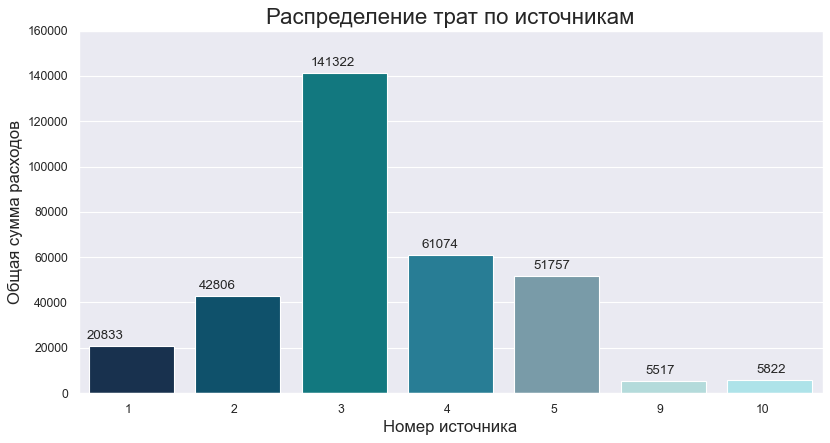

In [75]:
plt.figure(figsize=(12,6), dpi=80)
plt.title('Распределение трат по источникам', size=20)
ax = sns.barplot(x=costs_table['source_id'], y=costs_table['costs'], palette = colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
for p in ax.patches:
        ax.annotate(str(round(p.get_height())), (p.get_x() * 1.05, p.get_height() + 3000))
plt.xlabel('Номер источника', size=15)
plt.ylabel('Общая сумма расходов', size=15)
plt.ylim(None, 160000)
plt.show()

Наибольшая сумма трат за отчетный период была произведена на источник 3 - около 141 322 у.е. Наименьшая сумма расходов принадлежит источнику 9 - 5517 у.е.

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика;

In [76]:
costs['month'] = costs['dt'].astype('datetime64[M]') #Перевод столбца dt в формат даты

Составим таблицу, сгруппировав затраты по месяцам и найдем их суммы. Затем соединим ее с таблицей report, которые мы создавали в блоке с расчетом LTV.

In [77]:
monthly_costs = costs.groupby('month').agg({'costs':'sum'}).reset_index()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')

In [78]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [79]:
table_for_cac = report_new.pivot_table(index='first_order_month', columns='age', aggfunc='mean', values='cac')
table_for_cac.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091
2017-07-01,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,
2017-08-01,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,,
2017-09-01,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,,,
2017-10-01,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,,,,
2017-11-01,9.288870,9.28887,9.28887,9.28887,9.28887,9.28887,9.28887,,,,,
2017-12-01,8.741810,8.74181,8.74181,8.74181,8.74181,8.74181,,,,,,
2018-01-01,9.937302,9.937302,9.937302,9.937302,9.937302,,,,,,,
2018-02-01,8.962758,8.962758,8.962758,8.962758,,,,,,,,


Построим график распределения CAC по месяцам.

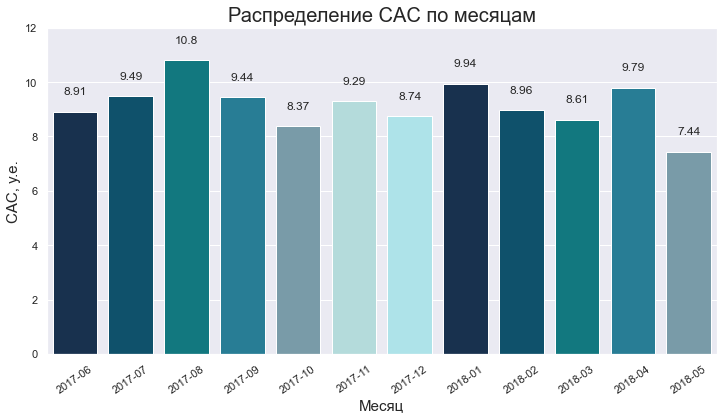

In [80]:
plt.figure(figsize=(12,6))
plt.title('Распределение CAC по месяцам', size=20)
ax = sns.barplot(y=table_for_cac.mean(axis=1), 
                 x=table_for_cac.index.to_series().dt.strftime('%Y-%m'), 
                 palette = colors)
plt.xticks(rotation=35)
for p in ax.patches:
        ax.annotate (str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Месяц', size=15)
plt.ylabel('СAC, у.е.', size=15)
plt.ylim(None, 12)
plt.show()

По графику видим, что самая высокая стоимость привлечения клиента наблюдается в августе 2017 года - 10.8 у.е., а самая низкая - в  мае 2018 года - 7.44 у.е.

Посчитаем метрику CAC по каналам.

Отсортируем таблицу visits по столбцу start_ts и сгруппируем по uid по дате первого входа.

In [81]:
visits_source = visits.sort_values('start_ts').groupby('uid').first()

In [82]:
visits_source = visits_source[['source_id']]

Соединим таблицы с заказами и визитами по uid пользователя и сгруппируем получившуюся таблицу по дате первого заказа и ресурсам. Найдем количество уникальных покупателей.

In [83]:
orders_source = orders.merge(visits_source, on='uid', how='left')
orders_source['first_order_date'] = orders_source['first_order_date'].astype('datetime64[D]')
buyers_source = orders_source.groupby(['source_id', 'first_order_date']).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'}).reset_index()
into_datetime(buyers_source, 'first_order_date') #Перевод даты первого заказа в формат даты

Соединим таблицу с покупателями buyers_source с таблицей с расходами costs по дате первого заказа и по ресурсам.
Найдем значения CAC, а затем сделаем сводную таблицу по значению CAC для разных когорт в разрезе каналов.

In [84]:
cac_source_table = pd.merge(buyers_source, costs, left_on = ['source_id', 'first_order_date'], right_on=['source_id', 'dt'])
cac_source_table['cac_source'] = cac_source_table['costs'] / cac_source_table['n_buyers']
cac_pivot_source = cac_source_table.pivot_table(index='month', columns='source_id', values='cac_source', aggfunc='mean')

In [85]:
cac_pivot_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054483,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


Найдем средние значения CAC, сгруппировав получившиеся значения CAC по источникам.

In [86]:
cac_source_table_mean_new = orders_source.groupby(['source_id'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'})\
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')\
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])
cac_source_table_mean_new = cac_source_table_mean_new[['source_id', 'cac']]

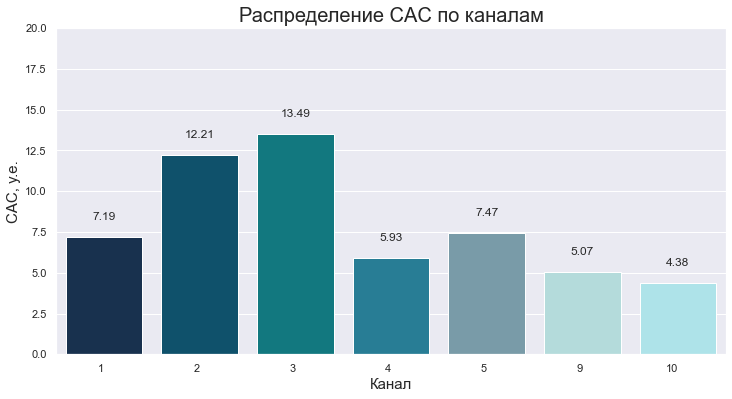

In [87]:
plt.figure(figsize=(12,6))
plt.title('Распределение CAC по каналам', size=20)
ax = sns.barplot(x=cac_source_table_mean_new['source_id'], y=cac_source_table_mean_new['cac'], palette = colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
for p in ax.patches:
        ax.annotate (str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Канал', size=15)
plt.ylabel('СAC, у.е.', size=15)
plt.ylim(None, 20)
plt.show()

По графику видим, что наиболее высокий CAC по 2 и 3 каналу - 12.21 и 13.49 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 5.07 и 4.38 у.е. 

In [88]:
orders_source.groupby(['source_id'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'})\
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')\
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])\
    .set_index('source_id')[['cac']].style.bar(color='#98C6FF')

,cac
source_id,
1,7.186364
2,12.209367
3,13.493901
4,5.931779
5,7.467480
9,5.071223
10,4.381106


#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV.

Рассчитаем ROMI по когортам.

In [89]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi_table = report_new.pivot_table(index='first_order_month', columns='age', aggfunc='mean', values='romi').cumsum(axis=1)
romi_table.index = romi_table.index.to_series().dt.strftime('%Y-%m')

Создадим тепловую карту и проанализируем изменение во времени ROMI по когортам.

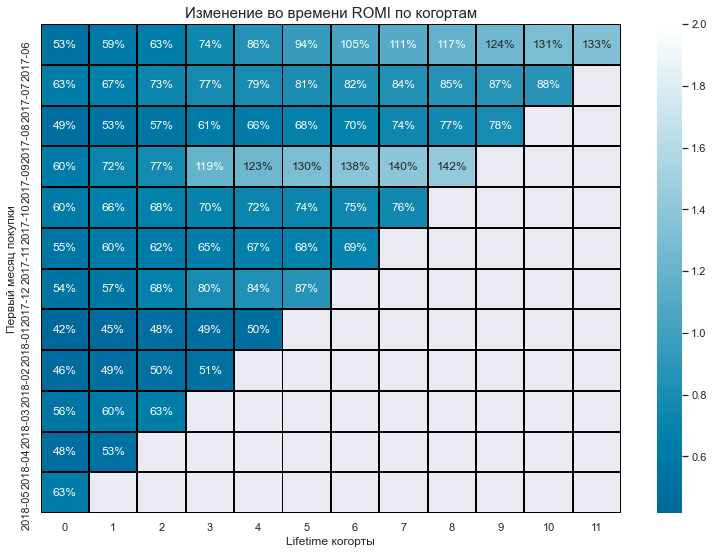

In [90]:
plt.figure(figsize=(13,9))
plt.title('Изменение во времени ROMI по когортам', size=15)
heatmap = sns.heatmap(romi_table, annot=True, fmt='.0%', 
                      linewidth=1, linecolor='black', vmax=2, center=0, cmap='ocean')
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

По графику видим, что наиболее рентабельной является июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Можно предположить, что сентябрьская когорта наиболее перспективная еще и потому что в сентябре начинается новый театральный сезон, что способствует привлечению все большего количества пользователей и является мотивацией активнее покупать билеты на Яндекс.Афише. Что касается первой когорты, возможно ее окупаемость связана с большей "продолжительностью жизни", чем у остальных когорт (хотя если обратить внимание на июльскую когорту, данное утверждение будет сомнительным). В любом случае, июньская когорта - это своего рода круг лояльных пользователей. Январская и февральская когорты наименее перспективные - нужно пересматривать инвестиции в маркетинговую стратегию, поскольку на этих когортах они явно не эффективны.

**LTV, CAC и ROMI по каналам**

Проведем когортный анализ LTV по каналам, но уже в разрезе различных источников. Сгруппируем таблицу с первыми заказами по id пользователя и ресурсам и найдем дату первой покупки.

In [91]:
first_orders_source = orders_source.groupby(['uid', 'source_id']).agg({'buy_ts':'min'}).\
               rename(columns={'buy_ts':'first_order_month'}).reset_index()
first_orders_source['first_order_month'] = first_orders_source['first_order_month'].astype('datetime64[M]')

Cоздадим таблицу с количеством покупателей в каждой когорте, где будут отображаться наименования ресурсов. Посчитаем сумму прибыли по когортам и создадим общую таблицу, где будет отражаться вся необходимая информация по когортам.

In [92]:
cohort_sizes_source = first_orders_source.groupby(['first_order_month', 'source_id']).agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
margin_rate = 1
cohorts_source = orders_source.groupby(['first_order_month', 'order_month', 'source_id']).agg({'revenue':'sum'}).reset_index()
report_source = pd.merge(cohort_sizes_source, cohorts_source, on=['first_order_month', 'source_id'], how='right')

Посчитаем возраст каждой когорты и рассчитаем LTV в окончательной таблице.

In [93]:
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')
report_source['ltv_source'] = report_source['gp'] / report_source['n_buyers']

Найдем средние значения CAC по каждому источнику и соединим с таблицей, полученной на предыдущем шаге. И, наконец, рассчитаем ROMI для того чтобы в дальнейшем по данной таблице можно было бы создать срезы по разным источникам.

In [94]:
report_source_merge = report_source.merge(cac_source_table_mean_new, on='source_id')
report_source_merge['romi_source'] = report_source_merge['ltv_source'] / report_source_merge['cac']

Построим тепловые карты изменения во времени ROMI по когортам в разрезе источников.

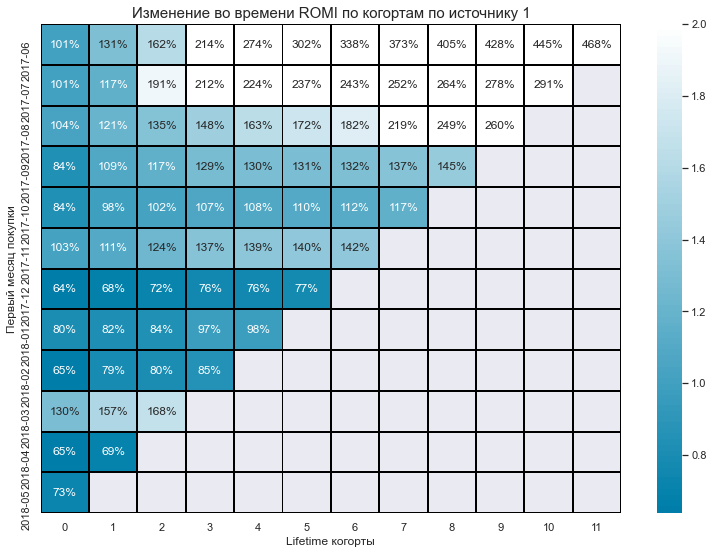

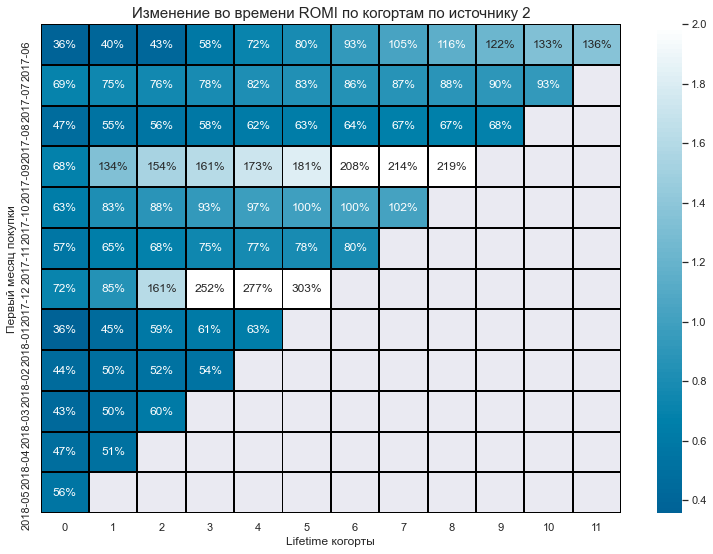

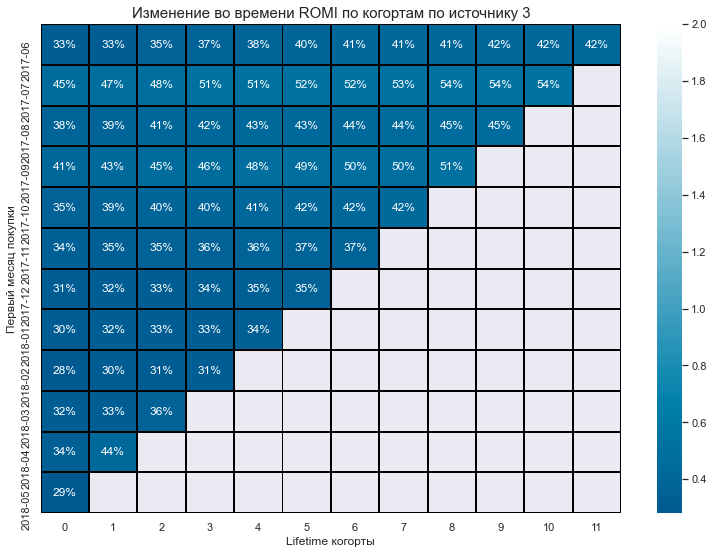

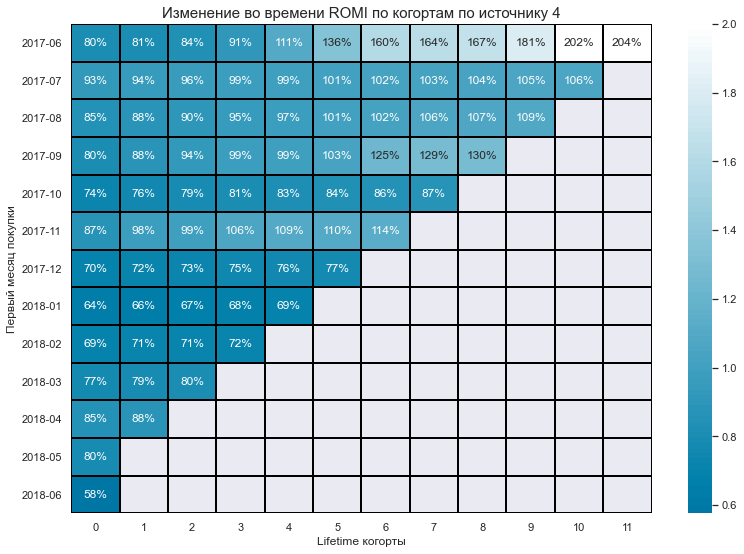

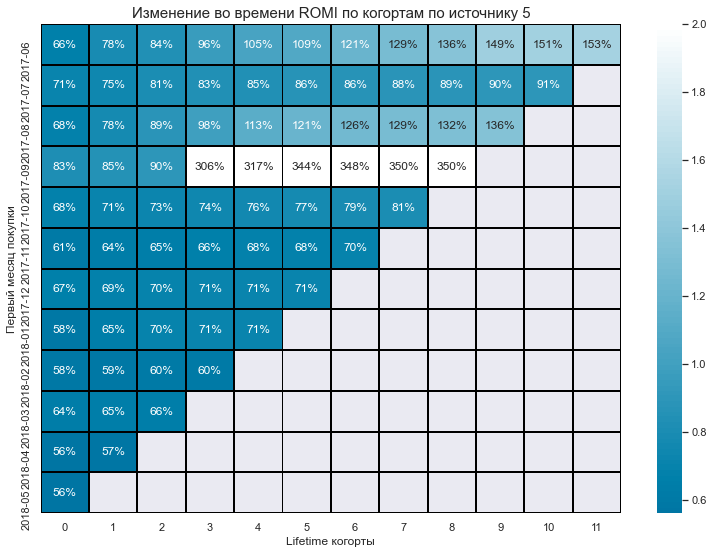

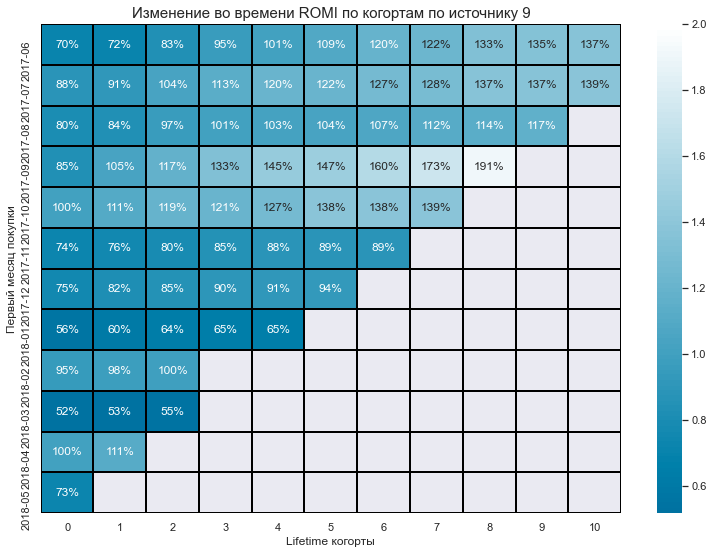

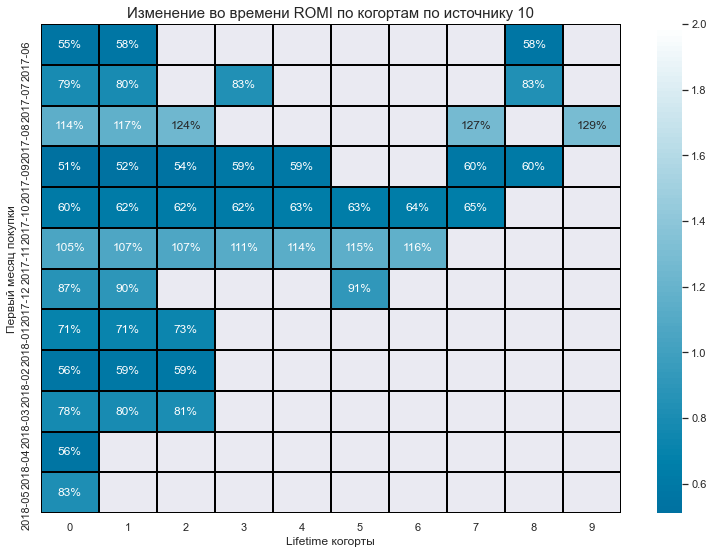

In [95]:
for i in report_source_merge['source_id'].unique():
    source_id_1 = report_source_merge.query('source_id == @i')
    romi_pivot_source = (source_id_1.pivot_table(index='first_order_month', 
                                                    columns='age', 
                                                    aggfunc='mean', 
                                                    values='romi_source').cumsum(axis=1))
    romi_pivot_source.index = romi_pivot_source.index.to_series().dt.strftime('%Y-%m')
    plt.figure(figsize=(13,9))
    plt.title('Изменение во времени ROMI по когортам по источнику {}'.format(i), size=15)
    heatmap = sns.heatmap(romi_pivot_source, annot=True, fmt='.0%', 
                      linewidth=1, linecolor='black', vmax=2, center=0, cmap='ocean')
    plt.xlabel('Lifetime когорты')
    plt.ylabel('Первый месяц покупки')
    plt.show()

По графикам видим, что наиболее эффективным оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце. Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Инвестиции в маркетинг для них начали окупаться на третьем месяце. Источник 3 не эффективен ни для одной когорты: рентабельность инвестиций колеблется в районе 29-50%. Источник 4 стал эффективным для первой когорты на пятом месяце. Источник 5 эффективен для сентябрьской, августовской и июньской когорт. Особенно для сентябрьской когорты данный канал "выстрелил". Рентабельность после отметки окупаемости на третьем месяце росла до 350%. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.

#### Вывод

Рассчитав маркетинговые метрики мы получили:

* Общая сумма расходов на маркетинг за весь период составила 329 131.59 у.е. 


* Наибольшая сумма трат за отчетный период была произведена на источник 3 - около 141 322 у.е. Наименьшая сумма расходов принадлежит источнику 9 - 5517 у.е.


* Самая высокая стоимость привлечения клиента наблюдается в августе 2017 года - 10.8 у.е., а самая низкая - в мае 2018 года - 7.44 у.е.


* Наиболее высокий CAC по 2 и 3 каналу - 12.21 и 13.49 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 5.07 и 4.38 у.е. 


* Наиболее рентабельной является июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Можно предположить, что сентябрьская когорта наиболее перспективная еще и потому что в сентябре начинается новый театральный сезон, что способствует привлечению все большего количества пользователей и является мотивацией активнее покупать билеты на Яндекс.Афише. Что касается первой когорты, возможно ее окупаемость связана с большей "продолжительностью жизни", чем у остальных когорт (хотя если обратить внимание на июльскую когорту, данное утверждение будет сомнительным). В любом случае, июньская когорта - это своего рода круг лояльных пользователей. Январская и февральская когорты наименее перспективные - нужно пересматривать инвестиции в маркетинговую стратегию, поскольку на этих когортах они явно не эффективны.


* Наиболее эффективным источником трафика оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце. Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Инвестиции в маркетинг для них начали окупаться на третьем месяце. Источник 3 не эффективен ни для одной когорты: рентабельность инвестиций колеблется в районе 25-45%. Источник 4 стал эффективным для первой когорты на пятом месяце. Источник 5 эффективен для сентябрьской, августовской и июньской когор. Особенно для сентябрьской когорты данный канал "выстрелил". Рентабельность после отметки окупаемости на третьем месяце росла до 314%. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.

## Шаг 3. Сформулируйте выводы и рекомендации

### Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему;

Наиболее эффективным оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце.  При этом на данный источник было потрачено 20 833 у.е, что меньше,чем допустим на источник 3 - около 141 322 у.е. 

Источник 5 эффективен для сентябрьской, августовской и июньской когорт. Особенно для сентябрьской когорты данный канал "выстрелил". Рентабельность после отметки окупаемости на третьем месяце росла до 314%. При этом затраты составили 51557 у.е.

Эти 2 источника трафика я бы рекомендовала для вложений. 


 Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Инвестиции в маркетинг для них начали окупаться на третьем месяце. В него также можно вкладываться, но с осторожностью. Я бы еще понаблюдала за динамикой в разрезе когорт. То же самое касается 9 и 10 когорт. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.
 
 Источник 3 не эффективен ни для одной когорты: рентабельность инвестиций колеблется в районе 25-45%. При этом на него было потрачено больше всего денежных средств: около 141 322 у.е . 

### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции;

Рассчитав продуктовые метрики мы получили:

* Количество уникальных пользователей в день (DAU) составляет 907, количество уникальных пользователей в неделю (WAU) - 5825, количество уникальных пользователей в месяц - 23 228.
Данный результат показывает, что мы постоянно привлекаем новых пользователей, они заходят на наш сервис, но пока не понятно насколько нам удается удержать привлеченных пользователей


* Оценили регулярность использования Яндекс.Афиши, рассчитав sticky factors. Получили, что sticky factors для WAU равен 15,88%, а для MAU равен 3.9%. Это не очень высокие показатели, а значит мы еще не сформировали круг лояльных пользователей, которые регулярно пользуются Яндекс.Афишей.


* За день пользователи заходят на сайт Яндекс.Афиши примерно 1,087 раз. Можно сказать, что это вполне объяснимый результат - люди обычно не мониторят по несколько раз на дню дайджест с интересными событиями, потому как правило обновления на таких сайтах не выгружаются каждую минуту. Достаточно 1 раз в день зайти на Яндекс.Афишу чтобы посмотреть куда можно сходить в ближайшее время.


* Наибольшее количество сессий продолжалось порядка 100 - 150 сек.(около 123 000 сессий). При этом получили, что что продолжительность типичной пользовательской сессии за весь период составляет 60 секунд. Возможно такая непродолжительность сессий связана с тем, что сторонние сервисы со сравнением цен от разных источников выкидывают пользователя сразу на страницу с оплатой, из-за чего продолжительность нахождения на сайте Яндекс.Афиши резко сокращается.


* Видим, что в первый месяц мы теряем больше 90% пользователей. При этом в последующие месяцы пользователи уже не так активно отказываются от услуг сервиса Яндекс.Афиши. Такое ощущение, что Яндекс.Афиша находит свою аудиторию, своих пользователей и удерживает это небольшое количество. Но показатели далеки от идеальных, нужно разбираться почему так много пользователей "отваливается" в течение первого месяца.


* Средний Retention Rate на второй месяц «жизни» когорт равен 6,5%. То есть мы теряем почти 94,5% пользователей по сравнению с предыдущим периодом.


Рассчитав метрики электронной коммерции, мы получили:
    
* Примерно 255 000 пользователей пердпочитают осуществлять покупки в первый же день. С момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут.



* Количество заказов на одного человека по каждой когорте составляет меньше 1 покупки в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше. Также видим, что по каждой когорте на первом месяце жизни пользователи делают 1 покупку, а затем данный показатель падает.


*  Среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43 покупки. Учитывая специфику платформы, можно предположить, что это вполне адекватный результат. Трудоспособная часть населения, у которых есть работа, обычно ходит на выставки, в театр и на другие мероприятия с периодичностью примерно раз в месяц. 


* Какой-либо четкой тенденции повышения/понижения среднего чека по когортам не наблюдается. Видим, что у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67 у.е., а также одно из самых высоких значений среднего чека наблюдается у декабрьской когорты в марте - 48.14 у.е. Общий средний чек по всем покупателям Яндекс.Афиши равен 5 у.е.


* У когорты 2017-09 накопительная выручка в перерасчете на количество людей была наиболее высокой у первой когорты начиная с 4 месяца и заканчивая 9 месяцем - она росла от 5.64 у.е. до 13.44 у.е. Из этого можно сделать вывод, что это наиболее перспективная когорта. При этом первая когорта 2017-06 также является перспективной, поскольку мы видим наиболее высокие значения LTV по сравнению с другим когортами на протяжении всего периода исследования. Более того, по первой когорте наблюдался наименьший отток пользователей (retention rate). Средний LTV по когортам за 6 месяцев равен 7.97 у.е.

Рассчитав маркетинговые метрики мы получили:

* Общая сумма расходов на маркетинг за весь период составила 329 131.59 у.е. 


* Наибольшая сумма трат за отчетный период была произведена на источник 3 - около 141 322 у.е. Наименьшая сумма расходов принадлежит источнику 9 - 5517 у.е.


* Самая высокая стоимость привлечения клиента наблюдается в августе 2017 года - 10.8 у.е., а самая низкая - в мае 2018 года - 7.44 у.е.


* Наиболее высокий CAC по 2 и 3 каналу - 16.29 и 15.58 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 6.84 и 6.56 у.е. 


* Наиболее рентабельной является июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Можно предположить, что сентябрьская когорта наиболее перспективная еще и потому что в сентябре начинается новый театральный сезон, что способствует привлечению все большего количества пользователей и является мотивацией активнее покупать билеты на Яндекс.Афише. Что касается первой когорты, возможно ее окупаемость связана с большей "продолжительностью жизни", чем у остальных когорт (хотя если обратить внимание на июльскую когорту, данное утверждение будет сомнительным). В любом случае, июньская когорта - это своего рода круг лояльных пользователей. Январская и февральская когорты наименее перспективные - нужно пересматривать инвестиции в маркетинговую стратегию, поскольку на этих когортах они явно не эффективны.


* Наиболее эффективным источником трафика оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце. Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Инвестиции в маркетинг для них начали окупаться на третьем месяце. Источник 3 не эффективен ни для одной когорты: рентабельность инвестиций колеблется в районе 29-50%. Источник 4 стал эффективным для первой когорты на пятом месяце. Источник 5 эффективен для сентябрьской, августовской и июньской когорт. Особенно для сентябрьской когорты данный канал "выстрелил". Рентабельность после отметки окупаемости на третьем месяце росла до 350%. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.


### Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

По результатам когортного анализа, наиболее перспективной является июньская и сентябрьская когорты. 

У июньской и сентябрьской когорты наблюдаются наибольшие средние чеки по всем месяцам 
Также у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67. 

У когорты 2017-09 накопительная выручка в перерасчете на количество людей была наиболее высокой начиная с 4 месяца и заканчивая 9 месяцем - она росла от 5.64 у.е. до 13.44 у.е. Из этого можно сделать вывод, что это наиболее перспективная когорта. При этом первая когорта 2017-06 также является перспективной, поскольку мы видим наиболее высокие значения LTV по сравнению с другим когортами на протяжении всего периода исследования. Более того, по первой когорте наблюдался наименьший отток пользователей (retention rate).

При расчете ROMI наиболее рентабельными также оказались июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Июньская когорта - это своего рода круг лояльных пользователей.